In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nmf_methods.nmf_son.utils import load_results, plot_and_merge, plot_W_mats, plot_combined_H, plot_separate_H

np.random.seed(42)
np.set_printoptions(precision=3)

In [3]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
#
# # Plot the matrix with imshow
# img = plt.imshow(M_2d, cmap='gray')
#
# # Add a rectangular box around the region of interest
# # rect = patches.Rectangle((60, 0), 40, 50, linewidth=2, edgecolor='r', facecolor='none')
# rect = patches.Rectangle((30, 10), 10, 10, linewidth=2, edgecolor='r', facecolor='none')
# plt.gca().add_patch(rect)
# plt.tight_layout()
#
# # Show the plot
# plt.savefig('../../experimental/nmfson_results/max_rank/outlined_subregion.png')

In [13]:
M = np.load('../../experimental/datasets/jasper_small.npz')['X']
m, n = M.shape

r = 20
# imgsize = (100, 100)
imgsize = (50, 40)
# imgsize = (10, 10)
figsize = (32, 8)
fontsize = 10
num_rows = 10
_lam = 1000
max_iters = 10000

In [14]:
save_filepath = '../../experimental/saved_models/jasper_small/r{}_l{}_mit{}.npz'
W, H, fscores, gscores, lvals = load_results(save_filepath.format(r, _lam, max_iters))

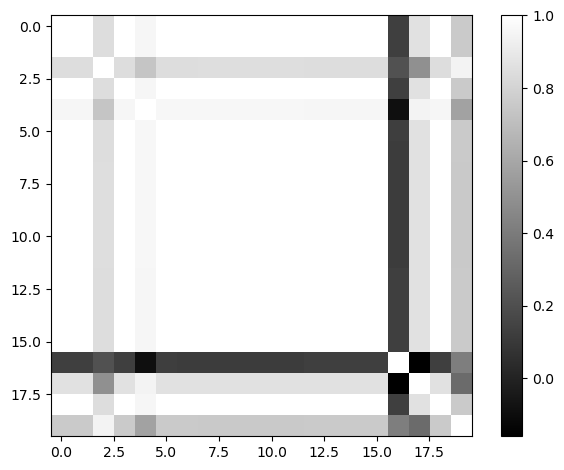

In [15]:
plt.imshow(np.corrcoef(W, rowvar=False), 'gray')
plt.colorbar()
plt.tight_layout()
plt.savefig('/Users/waqas/Desktop/nmfson_results/jasper_small/correlation_matrix.png')

In [16]:
img_filenames = ['/Users/waqas/Desktop/nmfson_results/jasper_small/unprocessed/w_plots.png',
                 '/Users/waqas/Desktop/nmfson_results/jasper_small/unprocessed/separate_h_plots.png',
                 '/Users/waqas/Desktop/nmfson_results/jasper_small/unprocessed/combined_h_plots.png',
                 '/Users/waqas/Desktop/nmfson_results/jasper_small/unprocessed/all_combined.png']
plot_and_merge(W, H, imgsize=imgsize, figsize=figsize, fontsize=fontsize, filenames=img_filenames, num_rows=2)

In [34]:
# unique_idxs = [4, 10, 13, 17]
unique_idxs = [2, 4, 16, 17, 19]
other_idxs = [x for x in range(r) if x not in unique_idxs]

In [35]:
# sum
hsum = H[other_idxs, :].sum(axis=0, keepdims=True)
wsum = W[:, other_idxs].sum(axis=1, keepdims=True)

new_W = np.hstack((W[:, unique_idxs], wsum))
new_H = np.vstack((H[unique_idxs, :], hsum))

In [36]:
img_filenames = ['../../experimental/nmfson_results/jasper_small/reduced_rank/w_plots.png',
                 '../../experimental/nmfson_results/jasper_small/reduced_rank/separate_h_plots.png',
                 '../../experimental/nmfson_results/jasper_small/reduced_rank/combined_h_plots.png',
                 '../../experimental/nmfson_results/jasper_small/reduced_rank/all_combined.png']
plot_and_merge(new_W, new_H, imgsize=imgsize, figsize=figsize, fontsize=fontsize, filenames=img_filenames, num_rows=1)

In [37]:
threshold = 0.2
tmp_H = new_H.copy()
tmp_H[tmp_H >= threshold] = 1
tmp_H[tmp_H < threshold] = 0

img_filenames = ['../../experimental/nmfson_results/jasper_small/after_thresholding/w_plots.png',
                 '../../experimental/nmfson_results/jasper_small/after_thresholding/separate_h_plots.png',
                 '../../experimental/nmfson_results/jasper_small/after_thresholding/combined_h_plots.png',
                 '../../experimental/nmfson_results/jasper_small/after_thresholding/all_combined.png']
plot_and_merge(new_W, tmp_H, imgsize=imgsize, figsize=figsize, fontsize=fontsize, filenames=img_filenames, num_rows=1)

In [26]:
# # mean
# havg = H[other_idxs, :].mean(axis=0, keepdims=True)
# wavg = W[:, other_idxs].mean(axis=1, keepdims=True)
#
# new_W = np.hstack((W[:, unique_idxs], wavg))
# new_H = np.vstack((H[unique_idxs, :], havg))

In [27]:
# max_idxs = np.argmax(new_H, axis=0)
# thres_H = np.zeros_like(new_H)
# thres_H[max_idxs, np.arange(new_H.shape[1])] = 1
#
# img_filenames = [f'../../experimental/images/jasper/w_r{r}_l{_lam}_mit{max_iters}_thres_max.png',
#                  f'../../experimental/images/jasper/seph_r{r}_l{_lam}_mit{max_iters}_thres_max.png',
#                  f'../../experimental/images/jasper/combh_r{r}_l{_lam}_mit{max_iters}_thres_max.png',
#                  f'../../experimental/images/jasper/r{r}_l{_lam}_mit{max_iters}_thres_max.png']
# plot_and_merge(new_W, thres_H, imgsize=imgsize, figsize=figsize, fontsize=10, filenames=img_filenames, num_rows=num_rows)

In [28]:
# for threshold in [0.1, 0.2,  0.3, 0.4, 0.5]:
#     tmp_H = new_H.copy()
#     tmp_H[tmp_H >= threshold] = 1
#     tmp_H[tmp_H < threshold] = 0
#
#     img_filenames = [f'../../experimental/images/jasper/w_r{r}_l{_lam}_mit{max_iters}_thres_{threshold}.png',
#                      f'../../experimental/images/jasper/seph_r{r}_l{_lam}_mit{max_iters}_thres_{threshold}.png',
#                      f'../../experimental/images/jasper/combh_r{r}_l{_lam}_mit{max_iters}_thres_{threshold}.png',
#                      f'../../experimental/images/jasper/r{r}_l{_lam}_mit{max_iters}_thres_{threshold}.png']
#     plot_and_merge(new_W, tmp_H, imgsize=imgsize, figsize=figsize, fontsize=10, filenames=img_filenames, num_rows=num_rows)